## Schrodinger Equation ##

We are going to solve the Schrodinger equation on a domain $\Omega_h$ with Dirichlet boundary contitions.

The equation to solve is:

$$
i \frac{\partial u}{\partial t} = \Delta u 
$$

Which we solve using,

$$
i (u - u_n) = dt *  \Delta (u + u_n)/2
$$

As time integrator, here $u = u_{n+1}$. Since the eigenvalues of $\Delta$ are proportional to $\Delta x^2$, $\lambda = -c/\Delta x^2$, $c > 0$, we must be carefull with the stability region of the method. We have, for each eigenfunction, 

$$
(i - \lambda dt/2)u = (i + \lambda dt /2 )u_n
$$

Thus, the amplification factor is: 

$$
|\frac{1 + i\lambda dt /2}{1 - i\lambda dt /2}| = 1
$$

and the system is unconditionaly stable.



We shall use its weak form,

$$
\int [2i v*u +  \nabla v \cdot \nabla u ] \; d\Omega = \int [2i*v*u_n - \nabla v \cdot \nabla u_n ] \; d\Omega
$$



In [3]:
import Pkg; Pkg.activate("gridap_makie")
using Gridap
using GridapMakie, GLMakie
using FileIO
#using Plots
#mkdir("models")
#mkdir("images")
using GridapGmsh
#using GridapGeosciences
#using Gridap.Arrays
#using Gridap.TensorValues
#using Gridap.ReferenceFEs
#using Gridap.Geometry
#using Gridap.Fields
#using Gridap.Algebra
#using SparseArrays
#using Gridap.FESpaces
#using Gridap.CellData

  Activating project at `~/Docencia/PDE/pde_private/Tareas/Tarea_7/gridap_makie`


In [4]:
l = 80
domain = (0,1,0,1)
partition = (1,1)
model = CartesianDiscreteModel(domain, partition)
# dynamic viscosity


T = 1/π            # final time for test
#T = 0.8
num_steps = 1601   # number of time steps for 128 T=3 
#num_steps = 12000   # number of time steps for 128 T=6 
#num_steps = 10000   # number of time steps for 64 T=3 
#num_steps = 50000   # number of time steps for 64 T=6 
dt = T / (num_steps-1) # time step size


# Intervals where data is saved
n_int = 160 # for 64
#mod = 60 # for 128
#mod = 120 # for 128 T=6
#mod = 240 # for 256 T=3
#mod = 480

test = false
bump = false
particle = false

#particle = true
test = true
    
file_name = "particle" #where to save things

println("dt / dx^2 = $(dt * l^2)   dt / dx = $(dt * l)  dt^3 / dx^6 = $((dt * l^2)^3)")

dt / dx^2 = 1.2732395447351628   dt / dx = 0.015915494309189537  dt^3 / dx^6 = 2.0640982037247677


The first number indicates what it would be the CFL condition for the explicit Euler method. The second a guide about taking time and space comparable steps. The third is proportinal to the error, obtained by expanding $\frac{1 + i\lambda dt /2}{1 - i\lambda dt /2} - e^{i\lambda dt} = (1 + i\lambda dt /2)(1 + i\lambda dt /2 - \frac{\lambda^2 dt^2}{4})  - (1 + i\lambda dt - \frac{\lambda^2 dt^2}{2}) = O(\lambda dt)^3 $

In [5]:
labels = get_face_labeling(model)
add_tag_from_tags!(labels,"diri_all",[1,2,3,4,5,6,7,8]);

In [6]:
order = 2
degree = order
Ωₕ = Triangulation(model)
dΩₕ = Measure(Ωₕ,degree)


Measure()

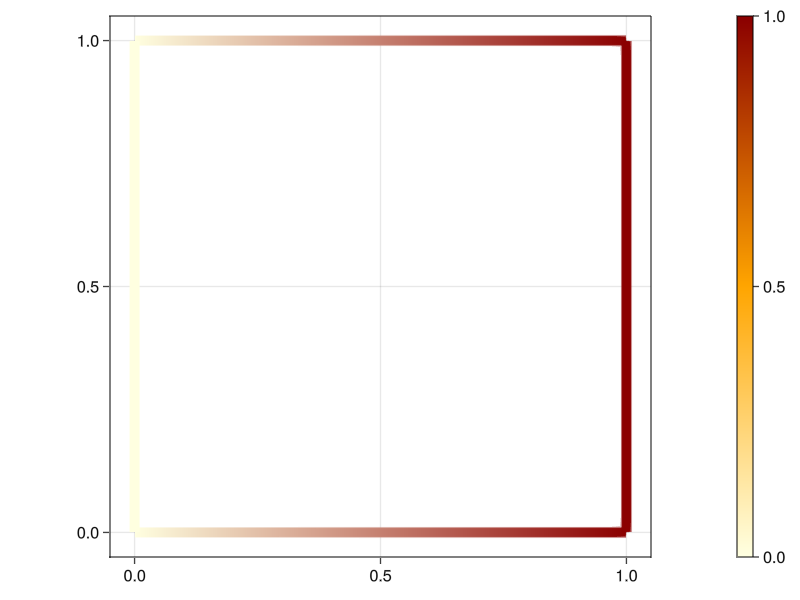

In [7]:
ue(x)=x[1]
Γ₁ = BoundaryTriangulation(model,tags=[5,6,7,8])
fig, ax , plt  = plot(Γ₁,ue, colormap=:heat, linewidth=10)
ax.aspect = AxisAspect(1)
Colorbar(fig[1,2], plt)
fig

#plot(Γ₁)

In [8]:
#scatter(BoundaryTriangulation(model,tags=[4]))


In [9]:
reffe = ReferenceFE(lagrangian,Float64,order)

(Lagrangian(), (Float64, 2), Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}())

In [10]:
V = TestFESpace(model,reffe,labels=labels,dirichlet_tags=["diri_all"],conformity=:H1,vector_type=Vector{ComplexF64})
U = TrialFESpace(V,0.0)

TrialFESpace()

In [11]:
ls = LUSolver()
solver = LinearFESolver(ls)

LinearFESolver()

In [12]:
norm_L2(u) = sqrt(real(sum(∫(u'*u)*dΩₕ)))

norm_L2 (generic function with 1 method)

In [13]:
function u_0_bump(x,par) 
    r0, r1, p = par
    r = sqrt((x[1]-0.5)^2 + (x[2]-0.5)^2)
    if r > r0 && r < r1
        return (r-r0)^p*(r-r1)^p * (4^(2p)) + 0.0*im
    else 
        return 0.0 + 0.0*im
    end
end

function u_0_particle(x,par)
    r0, xi, k, p = par
    r = sqrt((x[1]-xi[1])^2 + (x[2]-xi[2])^2)
    kx = 2π*(k[1]*(x[1]-xi[1]) + k[2]*(x[2]-xi[2]))
    if r < r0
        return (r-r0)^p*(r-r0)^p * (4^(2p))*exp(im*kx)
    else 
        return 0.0 + 0.0*im
    end
end
        


function u_0_test(x,p)
    n, m = p
    return sin(π*x[1]*n)*sin(π*x[2]*m)
end 
        
function test_solution(x,t,p)
    n, m = p
    ω = π^2*(n^2+m^2)
    return sin(π*x[1]*n)*sin(π*x[2]*m)*exp(im*ω*t)
end

par_bump = (0.25, 0.75, 4)
par_test = (2, 3)
par_particle = (0.4, [0.25;0.25], [-16;16], 4)

#u_0_bump([0.5;0.5], par_bump)
#u_0_test([0.5;0.5], par_test)    
u_0_particle([0.5;0.5], par_particle)


1.41942372254247e-6 + 0.0im

In [14]:
if test
    u_0(x) = u_0_test(x,par_test)
elseif bump
    u_0(x) = u_0_bump(x, par_bump)
elseif particle 
    u_0(x) = u_0_particle(x, par_particle)    
end

u_n = interpolate_everywhere(u_0,V)
#writevtk( Ωₕ,"Results/results_$(lpad(0,3,'0'))", cellfields=["uh_r"=>real(u_n),"uh_i"=>imag(u_n)])


SingleFieldFEFunction():
 num_cells: 1
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 4499753987727518170

In [15]:
fig, axₕlt = plot(Ωₕ, real(u_n))
ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
current_figure()
#fig

To generate just once the matrix A we follow this example: https://github.com/gridap/Gridap.jl/blob/master/test/FESpacesTests/AssemblersTests.jl



In [16]:
assem = SparseMatrixAssembler(U,V)
dv = get_fe_basis(V)
du = get_trial_fe_basis(U)

a(u,v) = ∫(∇(v) ⋅ ∇(u)*dt + im*2*v*u)dΩₕ

mat_contribs = a(du,dv)
data = collect_cell_matrix(U,V,mat_contribs)
A = assemble_matrix(assem,data)

t = 0
u_n = interpolate_everywhere(u_0,V)
writevtk(
          Ωₕ,"Results/"*file_name*"_$(lpad(0,3,'0'))",
          cellfields=["uh_r"=>real(u_n),"uh_i"=>imag(u_n)])

if test
    e = zeros(num_steps ÷ n_int)
end
    
for istep in 1:num_steps

    #println("\n+++ Solving in step $istep of $num_steps +++\n")
    t = t+dt
    b(v) = ∫(∇(v) ⋅ ∇(-u_n)*dt + im*2*v*u_n)dΩₕ
    vec_contribs = b(dv)
    data = collect_cell_vector(V,vec_contribs)
    b = assemble_vector(assem,data)
    
    #op = AffineFEOperator(a,b,U,V)
    #uh = solve(solver,op)
    x = A\b
    uh = FEFunction(U,x)
    
    u_n = uh
    
    if (istep-1) % n_int == 0 && istep > 1
        writevtk(
          Ωₕ,"Results/"*file_name*"_$(lpad(istep,3,'0'))",
          cellfields=["uh_r"=>real(u_n),"uh_i"=>imag(u_n)])
        if test 
            u_0(x) = test_solution(x,t,par_test)
            u_s = interpolate_everywhere(u_0,V)
            error = norm_L2(u_n - u_s)
            e[(istep-1) ÷ n_int] = error
            l2 = norm_L2(u_n)
            println("time = $t, rel_error = $(error/l2),      l2 = $l2")
        end
    end
        

end


LoadError: UndefVarError: collect_cell_matrix not defined

Vemos que el error tiene un crecimiento lineal, tal como se espera. 

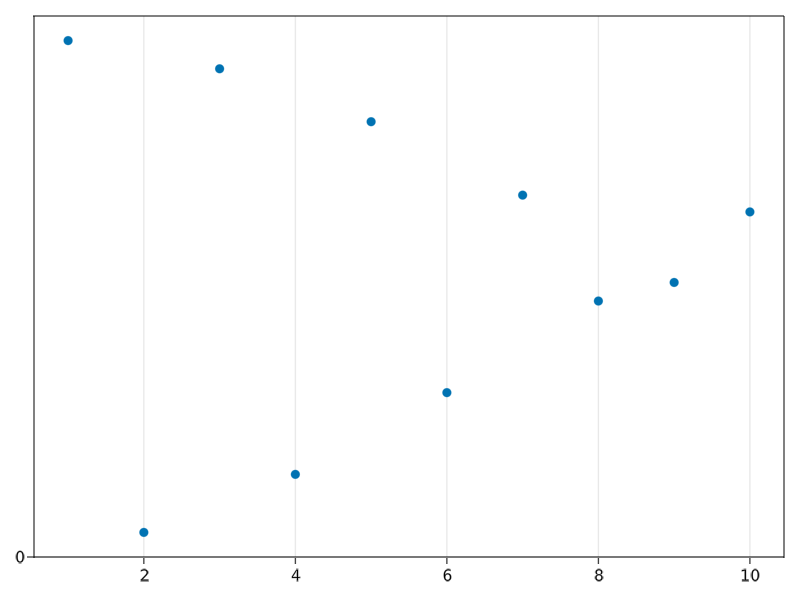

In [ ]:
if test
    scatter(e)
end